<a href="https://colab.research.google.com/github/arn97/MLTSA25_ARoy/blob/main/MLTSA_ARoy/HW5_ARoy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ruptures
import ruptures as rpt
import pylab as pl
import pandas as pd
import numpy as np
from scipy.optimize import minimize
%pylab inline




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


# Synthetic data
the cell below creates a synthetic dataset _(x,y)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(0,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and 25 respectively.

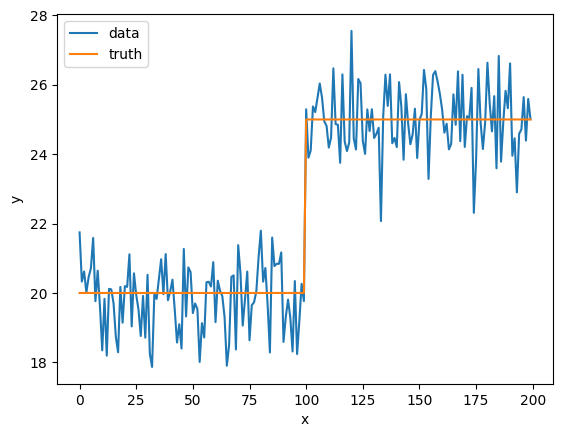

In [2]:
mu1, mu2 = 20, 25
x = np.arange(200)
ym = np.concatenate([np.random.randn(100) + mu1, np.random.randn(100) + mu2])
pl.plot(x, ym, label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, label="truth")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

# Single POC -  difference of means
write a function that finds the POC by assuming a single POC and maximizing the differencem in the means before and after the POC as described in
https://slides.com/federicabianco/mltsa4#/6/1
test it on the synthetic dataset _(x,y)_

In [3]:
def maxdiff(y):
    """calculates the POC as the points that maximized the difference between the mean before and the mean after the POC
    y: vector of endogenouos variables

    """
    N = len(y)
    f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(y[i:]) -  f(y[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(ym[:i]), f(ym[i:])
    return(poc, before, after)

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff(ym)))


poc: 100.00, mean before: 19.83, mean after: 25.00


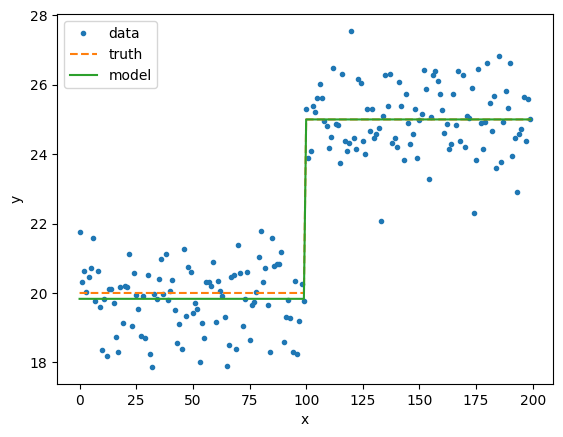

In [4]:
poc, before, after = maxdiff(ym)
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Plot of prediction by the maxdiff function for mu1, mu2 and the point of change for the ym dataset against the true values and true average. The function has predicted the averages with very high accuracy and the POC with perfect accuracy.

# Single POC - MSE
write a function that finds the POC by minimizing the square error (see slide https://slides.com/federicabianco/mltsa4#/6/2) a single POC and maximizing the differencem in the means before and after the POC. like before return the index of the POC, the mean before and the mean after the POC.
Plot the data, the model, the truth, like in the step above.


Remember to write a docstring for the function https://www.python.org/dev/peps/pep-0257/!

In [5]:
def poc_mse(y):
    """Calculates the POC by minimizing the mean squared error (MSE)
       assuming a single POC and maximizing the difference in means before and after the POC.

    Args:
        y: A vector of endogenous variables.

    Returns:
        A tuple containing the index of the POC, the mean before the POC,
        and the mean after the POC.
    """
    N = len(y)
    mse, poc, before, after = float('inf'), 0, np.nan, np.nan
    for i in range(1, N):
        before_mean = np.mean(y[:i])
        after_mean = np.mean(y[i:])
        mse_here = np.sum((y[:i] - before_mean)**2) + np.sum((y[i:] - after_mean)**2)
        diff_here = np.abs(after_mean - before_mean)
        if mse > mse_here and diff_here > 0:  # Check for improvement in MSE and non-zero difference
            mse = mse_here
            poc = i
            before, after = before_mean, after_mean
    return poc, before, after


poc, before, after = poc_mse(ym)

In [6]:
print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*poc_mse(ym)))


poc: 100.00, mean before: 19.83, mean after: 25.00


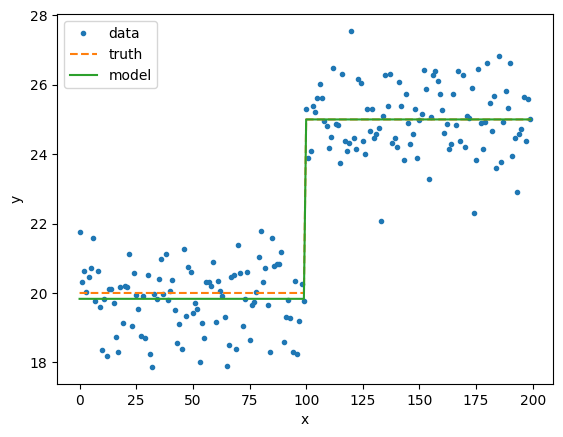

In [7]:
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Plot of prediction by the poc_mse function for mu1, mu2 and the point of change for the ym dataset against the true values and true average. The function has predicted the averages with very high accuracy and the POC with perfect accuracy. The prediction by poc_mse is almost same as the prediction by maxdiff.

# Single POC - diff of variance
Generate a new synthetic dataset _(x,ys)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(\sigma,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and variance 1 and 4 respectively.

Modify the ```maxdiff()``` function so that it take an optional parameter sigma which allows you to use the function to choose the POC that maximizes the different in standard deviation, instead of in mean. An optional argument is an argument that is set to a default in the function call. The default behavior of the function shoudl still be to calculate the POC as the point that maximized the before and after difference in the _mean_.


In [8]:
mu1 = 20
s1 = 1
s2 = 4
ys = np.concatenate([np.random.randn(100) * s1  + mu1 , np.random.randn(100) * s2 + mu1])

In [9]:
def maxdiff(y, sigma=False):
    """calculates the POC as the points that maximized the difference between
                the mean or variance before and the mean after the POC
    y: vector of endogenouos variables
    sigma: finds the POC that maximizes the difference between before/after POC variance
                (optional, default is before/after mean)
    """

    N = len(y)
    if sigma:
        f = np.nanstd
    else:
        f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(y[i:]) - f(y[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
    return(poc, before, after)

poc_s, before_s, after_s = maxdiff(ys, sigma=True)

print("poc: {:.2f}, std before: {:.2f}, std after: {:.2f}".format(*maxdiff(ys,
                                                                    sigma=True)))


poc: 100.00, std before: 1.04, std after: 4.33


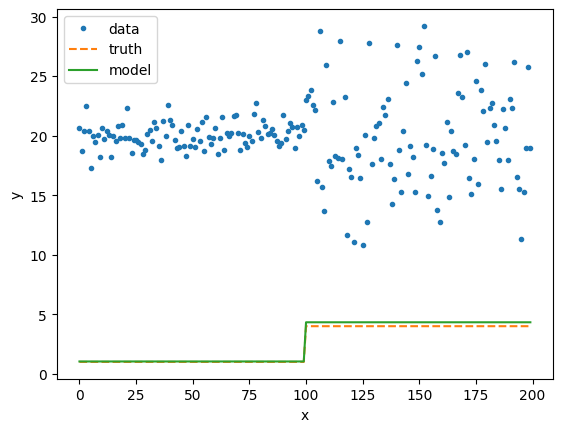

In [10]:
pl.plot(x, ys, '.', label="data")
pl.plot(range(200), [s1] * 100 + [s2] * 100, '--', label="truth")
pl.plot(x, [before_s] * poc_s + [after_s] * (len(ys) - poc_s), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Plot of prediction by the maxdiff function for s1, s2 and the point of change for the ys dataset against the true values and true variance. The function has predicted the variances with very high accuracy and the POC with perfect accuracy.

# Choose any of the function above and instead of optimizing them with a ``brute force'' method (i.e. with a for loop), use the `scipy.optimize.minimize` function (as done in the notebook about fitting lines to data).

In [11]:
def poc_mse_optimized(y):
    """Calculates the POC by minimizing the mean squared error (MSE)
       using scipy.optimize.minimize.

    Args:
        y: A vector of endogenous variables.

    Returns:
        A tuple containing the index of the POC, the mean before the POC,
        and the mean after the POC.
    """
    N = len(y)

    def objective_function(i):
        i = int(round(i))  # Ensure i is an integer
        if not 1 <= i < N:
            return np.inf  # Return infinity if i is outside valid range

        before_mean = np.mean(y[:i])
        after_mean = np.mean(y[i:])
        mse = np.sum((y[:i] - before_mean)**2) + np.sum((y[i:] - after_mean)**2)
        return mse

    # Initial guess for the POC (midpoint)
    initial_guess = N // 2

    # Optimization using minimize
    result = minimize(objective_function, initial_guess, bounds=[(1, N - 1)])
    poc = int(round(result.x[0]))

    before = np.mean(y[:poc])
    after = np.mean(y[poc:])

    return poc, before, after

poc_o, before_o, after_o = poc_mse_optimized(ym)
print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*poc_mse_optimized(ym)))

poc: 100.00, mean before: 19.83, mean after: 25.00


<ipython-input-11-85e68aea17a2>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(round(i))  # Ensure i is an integer


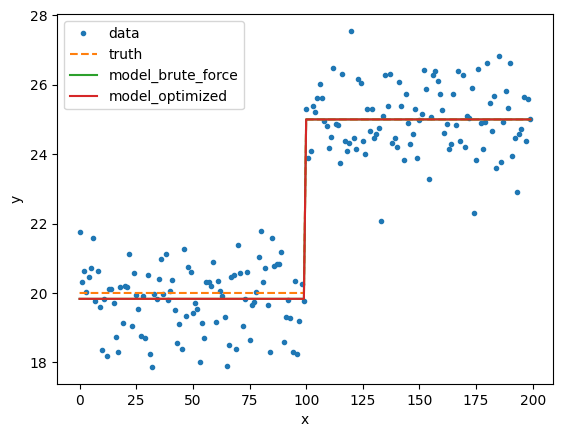

In [12]:
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model_brute_force")
pl.plot(x, [before_o] * poc_o + [after_o] * (len(ym) - poc_o), label="model_optimized")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();


Plot of prediction by the poc_mse function for mu1, mu2 and the point of change for the ym dataset against the true values and true average, but this version is using scipy.optimize.minimize. The function has predicted the averages with very high accuracy and the POC with perfect accuracy. The prediction by this version poc_mse is almost same as the prediction by the previous version.

# Find POC with rupture python package.
install and import the rupture package.
Find the POC in each synthetic time series.
Use the Pelt method. Reflect on the parameters that should be passed to the predict() function. Read the manual and feel free to ask questions on slack.

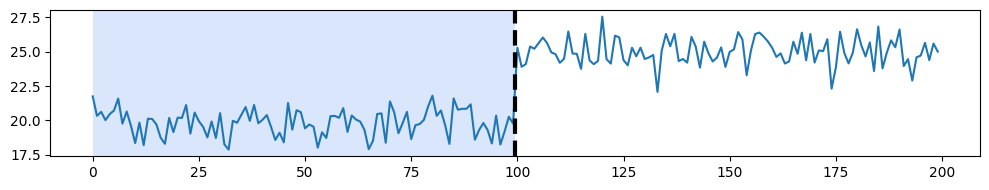

In [13]:
# detection
algo = rpt.Pelt(model='l2').fit(ym)
result = algo.predict(pen=10)

# display
rpt.display(ym, [100], result)
pl.show()

Caption: Plot of prediction by the Pelt method with l2 model in the rupture package for the point of change in the ym dataset. The function has predicted the POC almost perfectly.

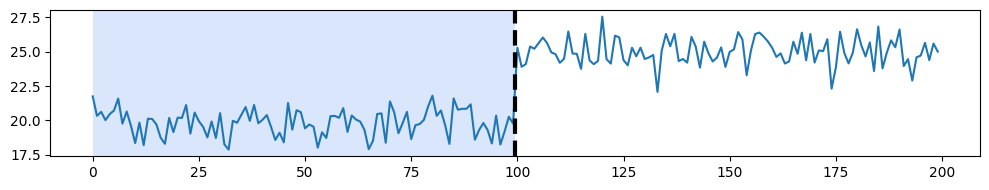

In [14]:
# detection
algo = rpt.Pelt(model='l1').fit(ym)
result = algo.predict(pen=10)

# display
rpt.display(ym, [100], result)
pl.show()

Caption: Plot of prediction by the Pelt method with l1 model in the rupture package for the point of change in the ym dataset. The function has predicted the POC almost perfectly.

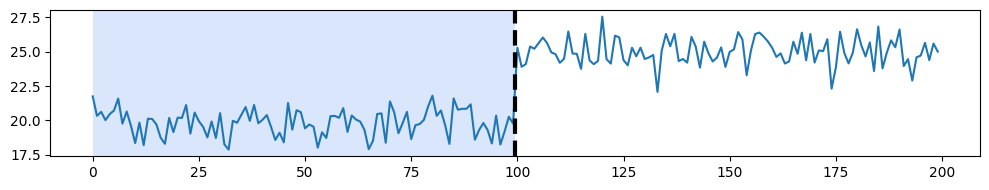

In [15]:
# detection
algo = rpt.Pelt(model='rbf').fit(ym)
result = algo.predict(pen=10)

# display
rpt.display(ym, [100], result)
pl.show()

Caption: Plot of prediction by the Pelt method with rbf model in the rupture package for the point of change in the ym dataset. The function has predicted the POC almost perfectly.

/usr/local/lib/python3.11/dist-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


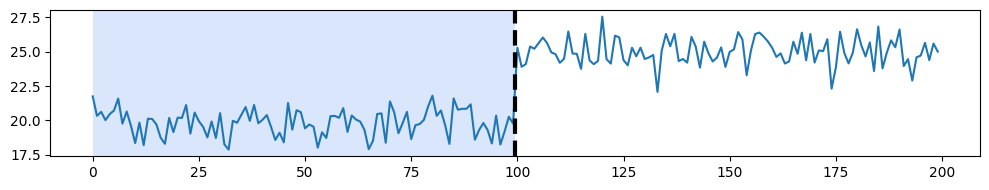

In [16]:
# detection
algo = rpt.Pelt(model='normal').fit(ym)
result = algo.predict(pen=20)

# display
rpt.display(ym, [100], result)
pl.show()

Caption: Plot of prediction by the Pelt method with normal model in the rupture package for the point of change in the ym dataset. The function has predicted the POC almost perfectly.

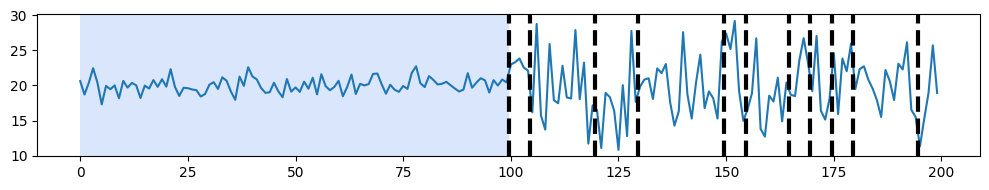

In [17]:
# detection
algo = rpt.Pelt(model='l2').fit(ys)
result = algo.predict(pen=10)

# display
rpt.display(ys, [100], result)
pl.show()

Caption: Plot of prediction by the Pelt method with l2 model in the rupture package for the point of change in the ys dataset. The function has predicted the actual POC almost perfectly but it detected some additional points as pocs which are not really pocs.

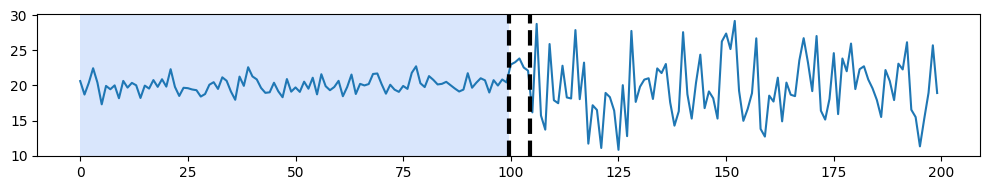

In [18]:
# detection
algo = rpt.Pelt(model='l1').fit(ys)
result = algo.predict(pen=10)

# display
rpt.display(ys, [100], result)
pl.show()

Caption: Plot of prediction by the Pelt method with l1 model in the rupture package for the point of change in the ys dataset. The function has failed to predict any POC.

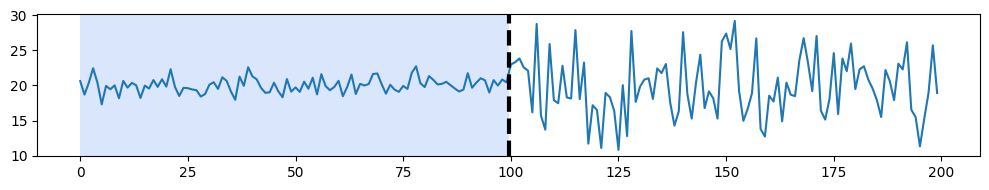

In [19]:
# detection
algo = rpt.Pelt(model='rbf').fit(ys)
result = algo.predict(pen=10)

# display
rpt.display(ys, [100], result)
pl.show()

Caption: Plot of prediction by the Pelt method with rbf model in the rupture package for the point of change in the ys dataset. The function has predicted the actual POC almost perfectly.

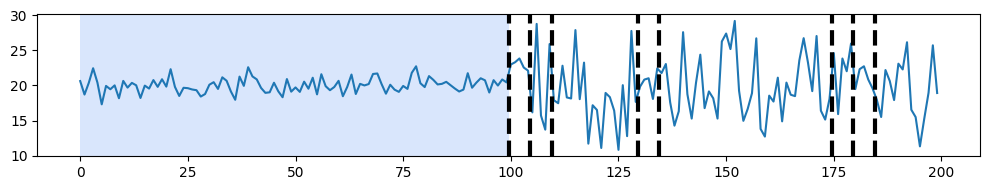

In [20]:
# detection
algo = rpt.Pelt(model='rbf').fit(ys)
result = algo.predict(pen=1)

# display
rpt.display(ys, [100], result)
pl.show()

Caption: Plot of prediction by the Pelt method with rbf model in the rupture package for the point of change in the ys dataset. The penalty was reduced to 1. The function has predicted the actual POC almost perfectly but it detected two additional false POCs.

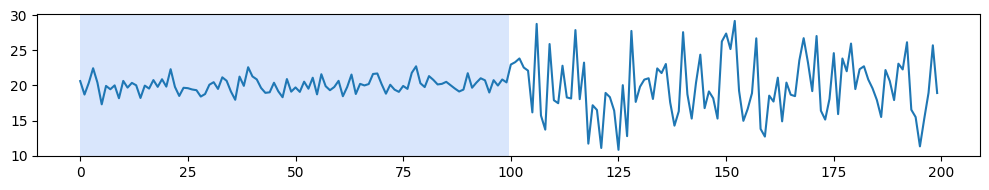

In [21]:
# detection
algo = rpt.Pelt(model='rbf').fit(ys)
result = algo.predict(pen=100)

# display
rpt.display(ys, [100], result)
pl.show()

Caption: Plot of prediction by the Pelt method with rbf model in the rupture package for the point of change in the ys dataset. The penalty was increased to 100. The function failed to predict any poc.

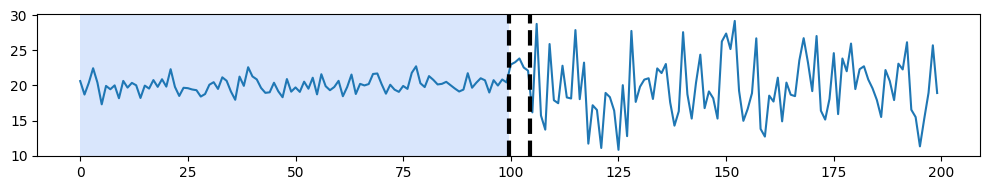

In [22]:
# detection
algo = rpt.Pelt(model='normal').fit(ys)
result = algo.predict(pen=10)

# display
rpt.display(ys, [100], result)
pl.show()

Caption: Plot of prediction by the Pelt method with normal model in the rupture package for the point of change in the ys dataset. The function has predicted the actual POC almost perfectly.

##Reflection on parameters for predict() function:##
pen: The penalty value controls the number of change points detected. A higher penalty leads to fewer change points, while a lower penalty leads to more change points. Hence we need to choose a penalty value that is not too large to detect the true POC and also not too small to detect some noise in the data as POC. For example when we are trying to identify the POC at t = 100 for the ys time series using the 'rbf' model we see that when pen=10 the algorithm is detecting the POC accurately and not detecting any false POC. When pen=1 the algorithm is detecting several more false POCs in addition to the actual POC. And finally pen=100 the algorithm fails to detect even the true POC.

# read in the data from LANL earthquake prediction
I saved in the github repo as "http://fbb.space/mltsa/LALNeq.csv. This is a large file and will take a long time to read in. It is 1/100th of the original file. See how nice I am!?! https://www.kaggle.com/c/LANL-Earthquake-Prediction/data

Visualize and use the method DataFrame.describe() to extract some basic statistics of the dataset

In [23]:
eq1 = pd.read_csv("http://fbb.space/mltsa/LALNeq.csv")
eq1.describe()

,Unnamed: 0,acoustic_data,time_to_failure
count,4.500000e+06,4.500000e+06,4.500000e+06
mean,2.250000e+06,4.616407e+00,8.852012e-01
std,1.299038e+06,2.614006e+01,3.374432e-01
min,0.000000e+00,-4.621000e+03,3.008971e-01
25%,1.125000e+06,2.000000e+00,5.934956e-01
50%,2.250000e+06,5.000000e+00,8.849986e-01
75%,3.374999e+06,7.000000e+00,1.177597e+00
max,4.499999e+06,3.252000e+03,1.469100e+00


In [24]:
eq1.head()

,Unnamed: 0,acoustic_data,time_to_failure
0,0,12,1.4691
1,1,6,1.4691
2,2,8,1.4691
3,3,5,1.4691
4,4,8,1.4691


# using rupture

Go through the documentation of rupture.

Find a method that takes as input the number of pocs and has computational complexity O(kN^2) and run it for k=1,2,3 pocs on the first N=10,000, 5000, and 1000 rows of the datasets respectively (make a plot for each and discuss each in the caption)




In [25]:
signal = eq1.acoustic_data.values

/usr/local/lib/python3.11/dist-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


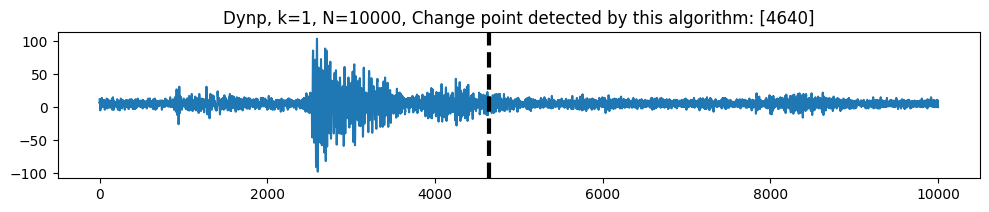

In [26]:
algo11 = rpt.Dynp(model="normal").fit(signal[:10000])
result11 = algo11.predict(n_bkps=1)

# display
rpt.display(eq1.acoustic_data.values[:10000], [], result11)
plt.title(f"Dynp, k=1, N=10000, Change point detected by this algorithm: {result11[:-1]}")
plt.show()


Caption: The only method of rupture that satisfies the two given criteria I could find is the Dynp or Dynamic Programming method. The plot above is the for the output of Dynp method with normal model for k = 1 and n = 10000. As we can see since the model was asked to only detect one POC it detected a POC but theat does not seem to be the most significant one visually which lies around the 2600 mark.

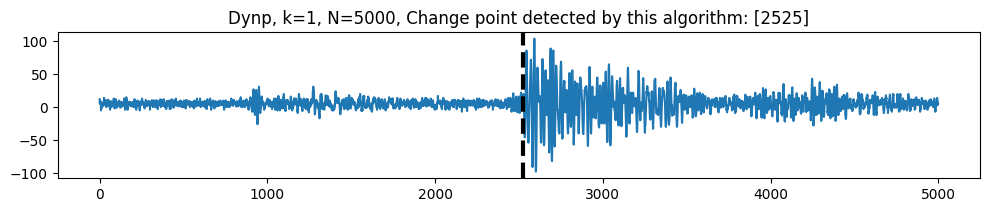

In [27]:
algo12 = rpt.Dynp(model="normal").fit(signal[:5000])
result12 = algo12.predict(n_bkps=1)

# display
rpt.display(eq1.acoustic_data.values[:5000], [], result12)
plt.title(f"Dynp, k=1, N=5000, Change point detected by this algorithm: {result12[:-1]}")
plt.show()

Caption: The above plot is the output for the same method but this time we providing only first 5000 rows instead of 10000. Even with half the data the algorithm detected the most significant POC. So providing less data seemingly improved the model.

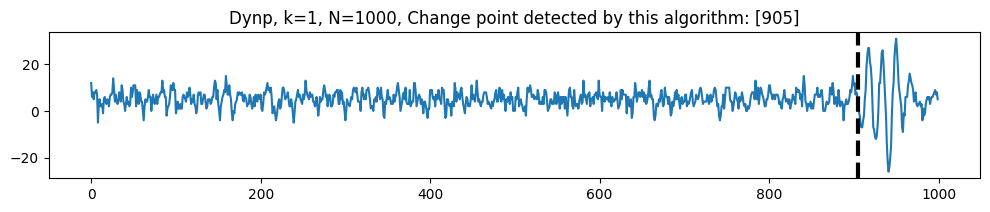

In [28]:
algo13 = rpt.Dynp(model="normal").fit(signal[:1000])
result13 = algo13.predict(n_bkps=1)

# display
rpt.display(eq1.acoustic_data.values[:1000], [], result13)
plt.title(f"Dynp, k=1, N=1000, Change point detected by this algorithm: {result13[:-1]}")
plt.show()

Caption: The above plot is the output for the same method but this time we providing only first 1000 rows. This time the algrithm detected the POC at 945 and indeed visually there seems to be a clear increase in variance around the 950 mark.


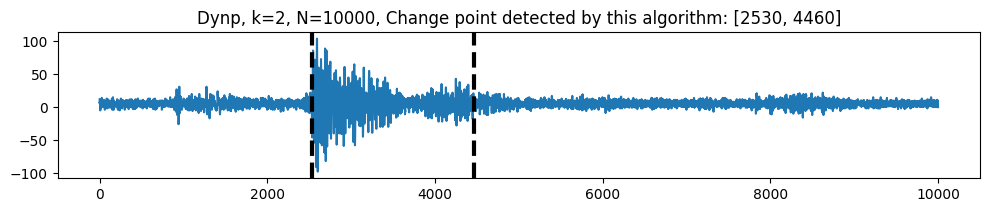

In [29]:
algo21 = rpt.Dynp(model="normal").fit(signal[:10000])
result21 = algo21.predict(n_bkps=2)

# display
rpt.display(eq1.acoustic_data.values[:10000], [], result21)
plt.title(f"Dynp, k=2, N=10000, Change point detected by this algorithm: {result21[:-1]}")
plt.show()

The model detected the two most visually prominent pocs when asked two detect two pocs(k=2) with the full 10000 datapoints.

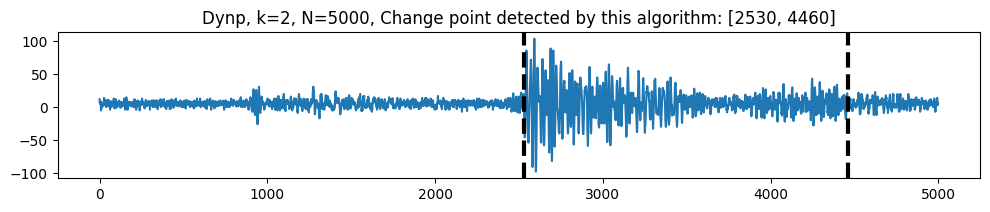

In [30]:
algo22 = rpt.Dynp(model="normal").fit(signal[:5000])
result22 = algo21.predict(n_bkps=2)

# display
rpt.display(eq1.acoustic_data.values[:5000], [], result22)
plt.title(f"Dynp, k=2, N=5000, Change point detected by this algorithm: {result22[:-1]}")
plt.show()

The model detected the two most visually prominent pocs when asked two detect two pocs(k=2) with the 5000 datapoints. The predictions are exactly same even with half the data.

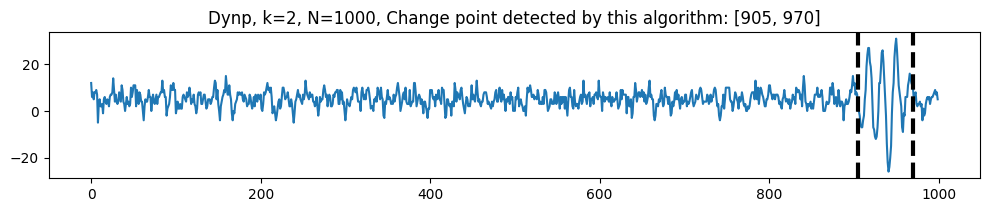

In [31]:
algo23 = rpt.Dynp(model="normal").fit(signal[:1000])
result23 = algo23.predict(n_bkps=2)

# display
rpt.display(eq1.acoustic_data.values[:1000], [], result23)
plt.title(f"Dynp, k=2, N=1000, Change point detected by this algorithm: {result23[:-1]}")
plt.show()

In the first 1000 datapoints there is clearly a region of higher variance in between 940 to 980. The method detected the two endpoints of this region.

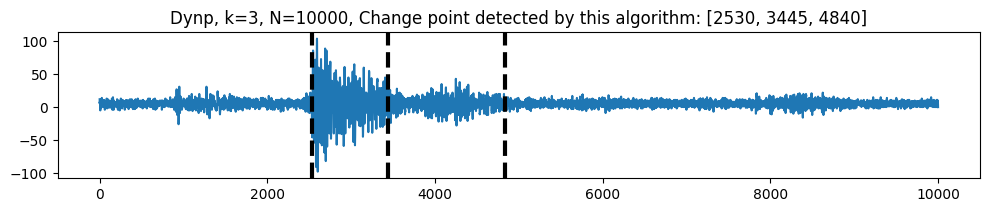

In [32]:
algo31 = rpt.Dynp(model="normal").fit(signal[:10000])
result31 = algo31.predict(n_bkps=3)

# display
rpt.display(eq1.acoustic_data.values[:10000], [], result31)
plt.title(f"Dynp, k=3, N=10000, Change point detected by this algorithm: {result31[:-1]}")
plt.show()

The model detected the three most visually prominent pocs when asked two detect two pocs(k=2) with the full 10000 datapoints.

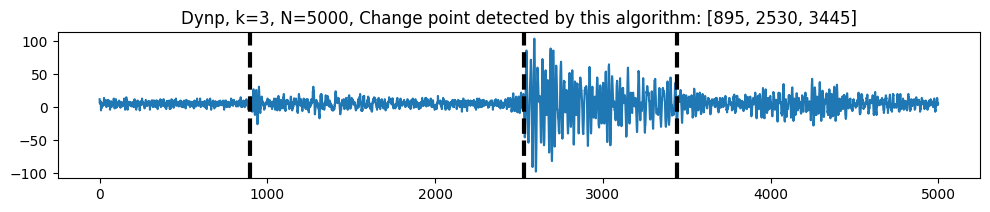

In [33]:
algo32 = rpt.Dynp(model="normal").fit(signal[:5000])
result32 = algo32.predict(n_bkps=3)

# display
rpt.display(eq1.acoustic_data.values[:5000], [], result32)
plt.title(f"Dynp, k=3, N=5000, Change point detected by this algorithm: {result32[:-1]}")
plt.show()

When given only 5000 points and asked to detect 3 POCs, the algorithm failed to detect the POC around 4840. Instead it detected the poc at 895.

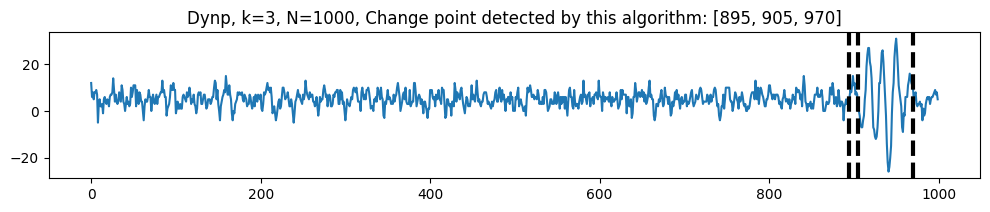

In [34]:
algo33 = rpt.Dynp(model="normal").fit(signal[:1000])
result33 = algo33.predict(n_bkps=3)

# display
rpt.display(eq1.acoustic_data.values[:1000], [], result33)
plt.title(f"Dynp, k=3, N=1000, Change point detected by this algorithm: {result33[:-1]}")
plt.show()

In the first 1000 datapoints there is clearly a region of higher variance in between 940 to 980. The method detected the two endpoints of this region. However there does not seem to be any more POCs in this region. Therefore the algorithm detected two POCs very close to each other.

Find a method that has computational complexity O(Nlog(N))

Run both methods on the full 10000 rows dataset with the goal is to isolate 3 chunks of the time series. Read about the methods you choose, and describe the constraints you imposed and the paraemters you choose.

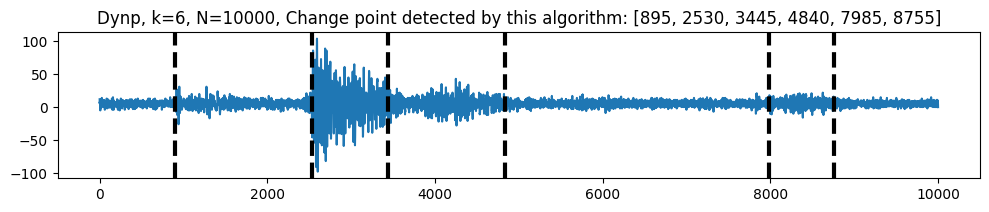

In [37]:
algo6D = rpt.Dynp(model="normal").fit(signal[:10000])
result6D = algo6D.predict(n_bkps=6)

# display
rpt.display(eq1.acoustic_data.values[:10000], [], result6D)
plt.title(f"Dynp, k=6, N=10000, Change point detected by this algorithm: {result6D[:-1]}")
plt.show()

Caption: Plot for Dynp method on the full dataset with k=6.

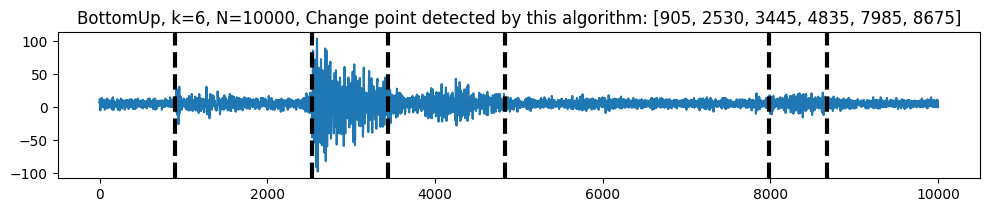

In [39]:
algo6B = rpt.BottomUp(model="normal").fit(signal[:10000])
result6B = algo6B.predict(n_bkps=6)

# display
rpt.display(eq1.acoustic_data.values[:10000], [], result6B)
plt.title(f"BottomUp, k=6, N=10000, Change point detected by this algorithm: {result6B[:-1]}")
plt.show()

Caption: Plot for BottomUP method on the full dataset with k=6.

caption (note that your plot does not need to look exactly like mine